# Import the libraries

In [1]:
import numpy as np
import pandas as pd

import os
import shutil

import pickle as pk

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.applications import VGG16

In [9]:
list_manga_training = 675
list_classic_training = 686

list_manga_validation = 250
list_classic_validation = 250


list_manga_test = 30
list_classic_test = 30

# Data pre-processing

## Train-Validation-Test Split

## Obtaining the lists of randomly selected images

In [4]:
#Number of manga style training images= 675
#Number of classic style training images= 686
#Number of manga style validation images= 250
#Number of classic style validation images= 250
#Number of manga style test images= 30
#Number of classic style test images= 30

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Determination of the directories

In [6]:
root_directory = os.getcwd()

train_dir = os.path.join(root_directory, '/content/drive/MyDrive/Comics/train')
validation_dir = os.path.join(root_directory, '/content/drive/MyDrive/Comics/validation')
test_dir = os.path.join(root_directory, '/content/drive/MyDrive/Comics/test')

## Obtain the total number of training, validation and test images

In [11]:
num_manga_img_train = list_manga_training
num_classic_img_train = list_classic_training

num_train_images_total = num_manga_img_train + num_classic_img_train

print('Total training manga images: ' + str(num_manga_img_train))
print('Total training classic images: ' + str(num_classic_img_train))
print()
print('Total training images: ' + str(num_train_images_total))

Total training manga images: 675
Total training classic images: 686

Total training images: 1361


In [12]:
num_manga_img_validation = list_manga_validation
num_classic_img_validation = list_classic_validation

num_validation_images_total = num_manga_img_validation + num_classic_img_validation

print('Total validation manga images: ' + str(num_manga_img_validation))
print('Total validation classic images: ' + str(num_classic_img_validation))
print()
print('Total validation images: ' + str(num_validation_images_total))


Total validation manga images: 250
Total validation classic images: 250

Total validation images: 500


In [13]:
num_manga_img_test = list_manga_test
num_classic_img_test = list_classic_test

num_test_images_total = num_manga_img_test + num_classic_img_test

print('Total test manga images: ' + str(num_manga_img_test))
print('Total test classic images: ' + str(num_classic_img_test))
print()
print('Total test images: ' + str(num_test_images_total))

Total test manga images: 30
Total test classic images: 30

Total test images: 60


# Feature Extraction with Data Augmentation

## Name Definitions

In [14]:
checkpoint_no = 'ckpt_1_CNN_with_TF_VGG19_with_DataAug'
model_name = 'Animals_CNN_TF_VGG19_epoch_30_ES'

## Parameter Settings

In [15]:
img_height = 150
img_width = 150
input_shape = (img_height, img_width, 3)

n_batch_size = 32

n_steps_per_epoch = int(num_train_images_total / n_batch_size)
n_validation_steps = int(num_validation_images_total / n_batch_size)
n_test_steps = int(num_test_images_total / n_batch_size)

n_epochs = 30

num_classes = 2

print('Input Shape: '+'('+str(img_height)+', '+str(img_width)+', ' + str(3)+')')
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))
print()
print('Number of Classes: ' + str(num_classes))

Input Shape: (150, 150, 3)
Batch Size: 32

Steps per Epoch: 42

Validation Steps: 15
Test Steps: 1

Number of Epochs: 30

Number of Classes: 2


## Instantiating the VGG19 convolutional base

In [16]:
VGG19_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base = VGG19_base

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Instantiating a densely connected classifier

### Layer Structure

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 16812610 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 30


In [21]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 2097922 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights after freezing the conv base: 4


### Configuring the model for training

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Using ImageDataGenerator

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='categorical')

Found 1361 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Callbacks

In [26]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [27]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir,
                                   monitor='val_loss', save_best_only=True, mode='auto'),
                   EarlyStopping(monitor='val_loss', patience=5, mode='auto',
                                 min_delta = 0, verbose=1)]

## Fitting the model

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=42,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=n_validation_steps,
      callbacks=keras_callbacks)

Epoch 1/30
42/42 [==============================] - 542s 13s/step - loss: 0.6950 - accuracy: 0.6802 - val_loss: 0.5206 - val_accuracy: 0.7354
Epoch 2/30
42/42 [==============================] - 459s 11s/step - loss: 0.4749 - accuracy: 0.7818 - val_loss: 0.4487 - val_accuracy: 0.7937
Epoch 3/30
42/42 [==============================] - 459s 11s/step - loss: 0.4514 - accuracy: 0.7833 - val_loss: 0.4398 - val_accuracy: 0.8104
Epoch 4/30
42/42 [==============================] - 425s 10s/step - loss: 0.4241 - accuracy: 0.8066 - val_loss: 0.4320 - val_accuracy: 0.8125
Epoch 5/30
42/42 [==============================] - 455s 11s/step - loss: 0.4233 - accuracy: 0.7803 - val_loss: 0.4853 - val_accuracy: 0.7583
Epoch 6/30
42/42 [==============================] - 421s 10s/step - loss: 0.3831 - accuracy: 0.8337 - val_loss: 0.5896 - val_accuracy: 0.7042
Epoch 7/30
42/42 [==============================] - 423s 10s/step - loss: 0.3992 - accuracy: 0.8172 - val_loss: 0.4427 - val_accuracy: 0.8042
Epoch 

## Obtaining the best model values

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.688971,0.660647,0.490318,0.777083
1,2,0.481598,0.759217,0.447781,0.791667
2,3,0.458042,0.777276,0.467737,0.756250
3,4,0.426282,0.799850,0.470532,0.783333
4,5,0.413478,0.794582,0.447338,0.781250


In [ ]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
10,11,0.372105,0.820166,0.424468,0.80625


## Obtaining class assignments

In [ ]:
class_assignment = train_generator.class_indices

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'classic': 0, 'manga': 1}


## Validation

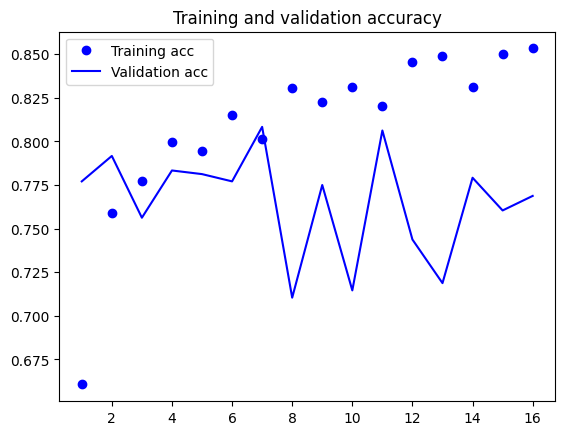

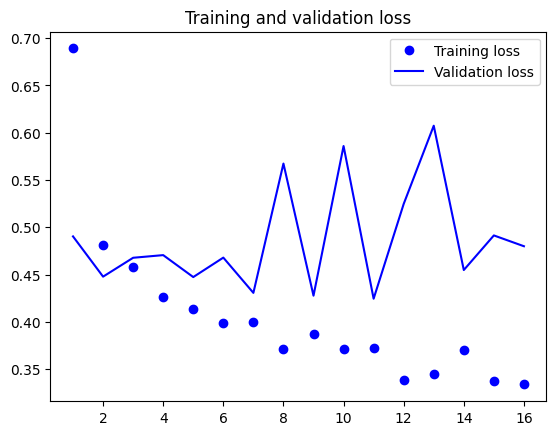

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load best model

In [ ]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folders/.pb file under Model Checkpoint File.
folder_name_temp1 = os.path.join(checkpoint_dir, 'assets')
folder_name_temp2 = os.path.join(checkpoint_dir, 'variables')
file_name_temp = os.path.join(checkpoint_dir, 'saved_model.pb')

shutil.move(file_name_temp, folder_name_temp1)
shutil.rmtree(folder_name_temp1, ignore_errors=True)
shutil.rmtree(folder_name_temp2, ignore_errors=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_model = load_model(model_name_temp)

## Model Testing

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='categorical')

test_loss, test_acc = best_model.evaluate(test_generator, steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

Found 80 images belonging to 2 classes.
1/1 [==============================] - 7s 7s/step - loss: 0.7793 - accuracy: 0.6250

Test Accuracy: 0.625


In [ ]:
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))

## Test Out of the Box Pictures

In [ ]:
# Determine Checkpoint Dir
checkpoint_dir = 'ckpt_1_CNN_with_TF_VGG19_with_DataAug'

# Load best model
best_model = load_model(checkpoint_dir + '/' + 'Animals_CNN_TF_VGG19_epoch_30_ES.h5')

# Load the categories
df = pd.read_csv(checkpoint_dir + '/' + 'class_assignment_df_Animals_CNN_TF_VGG19_epoch_30_ES.csv')
df = df.sort_values(by='Allocated Number', ascending=True)
CATEGORIES = df['Category'].to_list()


# Load the used image height and width
import pickle as pk

# Load the used image height and width
with open('/content/ckpt_1_CNN_with_TF_VGG19_with_DataAug\img_height.pkl', 'rb') as f:
    img_height_reload = pk.load(f)

with open('/content/ckpt_1_CNN_with_TF_VGG19_with_DataAug\img_width.pkl', 'rb') as f:
    img_width_reload = pk.load(f)

print('Used image height: ' + str(img_height_reload))
print('Used image width: ' + str(img_width_reload))

print('Model Summary :' + str(best_model.summary()))
print()
print()
print('CATEGORIES : ' + str(CATEGORIES))
print()
print('Used image height: ' + str(img_height_reload))
print('Used image width: ' + str(img_width_reload))

Used image height: 150
Used image width: 150
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 2097922 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Model Summary :None


CATEGORIES : ['classic', 'manga']

Used image height: 150
Used image widt

In [ ]:
/content/ckpt_1_CNN_with_TF_VGG19_with_DataAug\img_height.pkl
/content/ckpt_1_CNN_with_TF_VGG19_with_DataAug\img_width.pkl

AxesImage(size=(280, 260))
1/1 [==============================] - 0s 432ms/step

------------------------------------
Predicted Class: manga
------------------------------------


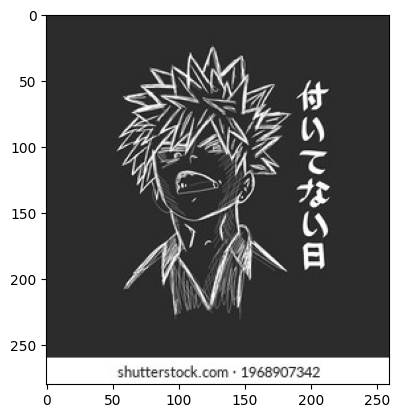

In [ ]:
img_pred = cv2.imread('/content/manga_img378.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = np.argmax(best_model.predict(img_pred), axis=-1)

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')